# Data Analysis

### Setup

In [173]:
# Libraries
import os
import sys
import re

import time
import datetime

import difflib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [174]:
# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 1000)

In [175]:
# Define path to the CSV files
data_path = "../data/raw/"

In [176]:
# Load the CSV data into a pandas DataFrame
try: 
    clients_df = pd.read_csv(os.path.join(data_path, "clients.csv"))
    sample_df = pd.read_csv(os.path.join(data_path, "sample.csv"))
    schedules_df = pd.read_csv(os.path.join(data_path, "schedules.csv"))
    translators_df = pd.read_csv(os.path.join(data_path, "translatorsCostPairs.csv"))
except FileNotFoundError as e:
    print(f"File not found: {e}")

### Overview

In [177]:
print("CSV Client Data")
display(clients_df.head())

print("CSV Sample Data")
display(sample_df.head())

print("CSV Schedules Data")
display(schedules_df.head())

print("CSV Translators Data")
display(translators_df.head())

CSV Client Data


,CLIENT_NAME,SELLING_HOURLY_PRICE,MIN_QUALITY,WILDCARD
0,Accesstra,25,7.0,Quality
1,AccuBank Industries,30,7.0,Deadline
2,AccuBuild Industries,35,7.5,Quality
3,AccuPulse,25,7.5,Deadline
4,Accura Systems,40,7.5,Price


CSV Sample Data


,PROJECT_ID,PM,TASK_ID,START,END,TASK_TYPE,SOURCE_LANG,TARGET_LANG,TRANSLATOR,ASSIGNED,READY,WORKING,DELIVERED,RECEIVED,CLOSE,FORECAST,HOURLY_RATE,COST,QUALITY_EVALUATION,MANUFACTURER,MANUFACTURER_SECTOR,MANUFACTURER_INDUSTRY_GROUP,MANUFACTURER_INDUSTRY,MANUFACTURER_SUBINDUSTRY
0,213494,KMT,10048285,2014-11-26 10:36:00,2014-11-26 15:30:00,Engineering,English,Portuguese (Brazil),Estela,2014-11-26 16:34:23,2014-11-26 16:34:25,2014-11-26 16:34:27,2014-11-26 17:50:07,2014-11-26 17:51:46,2014-11-26 17:51:48,0.25,24,6.00,7,Coastal Cottage,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure","Hotels, Resorts & Cruise Lines"
1,214198,KMT,10048285,2015-09-09 17:29:00,2015-09-10 11:00:00,Engineering,English,Spanish (Iberian),Jeronimo,2015-09-09 17:31:52,2015-09-09 17:34:56,2015-09-09 17:35:48,2015-09-10 16:42:21,2015-09-10 17:33:05,2015-09-10 17:33:07,1.50,20,30.00,7,HealthyLife,Health Care,Health Care Providers,Health Care Facilities,Long-Term Care Facilities
2,213094,PMT,10048285,2014-05-01 19:27:00,2014-05-02 19:00:00,Engineering,Catalan,Catalan,Octavi,2014-05-02 13:29:33,2014-05-02 13:29:35,2014-05-02 13:29:37,2014-05-02 13:29:39,2014-05-02 13:29:42,2014-05-02 13:29:44,0.33,15,4.95,6,AeroSysTech,Information Technology,Software & Services,Application Software,Systems Software
3,211967,KMT,10048285,2013-07-17 17:40:00,2013-08-31 18:00:00,Management,English,Spanish (Iberian),Ramiro Josafat,2013-07-22 15:35:11,2013-07-22 15:35:33,2013-08-30 15:55:01,2013-08-30 15:55:04,2013-08-31 16:28:14,2013-08-31 16:28:18,0.50,20,10.00,6,MetaPro,Industrials,Electrical Equipment,Electrical Components & Equipment,Electrical Components & Equipment
4,212331,PMT,10048285,2013-11-01 13:13:00,2013-10-31 19:00:00,Miscellaneous,Catalan,Catalan,Victor,2013-10-31 13:14:35,2013-10-31 13:18:25,2013-10-31 13:18:27,2013-10-31 13:18:29,2013-10-31 13:18:31,2013-10-31 13:18:34,0.00,11,0.00,8,SunTech,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals"


CSV Schedules Data


,NAME,START,END,MON,TUES,WED,THURS,FRI,SAT,SUN
0,Abigail,8:00:00 AM,6:00:00 PM,1,1,1,1,1,0,0
1,Abelardo,6:00:00 AM,4:00:00 PM,1,1,1,1,1,1,1
2,Margarita,8:00:00 AM,6:00:00 PM,1,1,1,1,1,1,1
3,Davide,9:00:00 AM,7:00:00 PM,1,1,1,1,1,1,1
4,Paul,7:00:00 AM,5:00:00 PM,1,1,1,1,1,1,1


CSV Translators Data


,TRANSLATOR,SOURCE_LANG,TARGET_LANG,HOURLY_RATE
0,Aaron,English,Basque,27
1,Aaron,English,Catalan,17
2,Aaron,English,Galician,20
3,Aaron,English,German,32
4,Aaron,English,Portuguese (Brazil),21


### Inspection

In [178]:
tuples_df = {
    "Clients": clients_df,
    "Sample": sample_df,
    "Schedules": schedules_df,
    "Translators": translators_df
}

In [179]:
print("MISSING VALUES", "\n")

for name, df in tuples_df.items():
    print(f"{name} Dataset")
    print(f"\t{df.isnull().sum().sum()} missing values")
    print()

MISSING VALUES 

Clients Dataset
	0 missing values

Sample Dataset
	0 missing values

Schedules Dataset
	0 missing values

Translators Dataset
	0 missing values



In [180]:
print("DUPLICATED VALUES", "\n")

for name, df in tuples_df.items():
    print(f"{name} Dataset")
    print(f"\t{df.duplicated().sum()} duplicated values")
    print()

DUPLICATED VALUES 

Clients Dataset
	0 duplicated values

Sample Dataset
	0 duplicated values

Schedules Dataset
	0 duplicated values

Translators Dataset
	0 duplicated values



In [181]:
print("UNIQUE VALUES", "\n")

for name, df in tuples_df.items():
    print(f"{name} Dataset")
    print(f"\tUnique Values:")
    for col in df.columns:
        print(f"\t\t{col}: {df[col].nunique()}")    
    print()

UNIQUE VALUES 

Clients Dataset
	Unique Values:
		CLIENT_NAME: 2646
		SELLING_HOURLY_PRICE: 14
		MIN_QUALITY: 4
		WILDCARD: 3

Sample Dataset
	Unique Values:
		PROJECT_ID: 1720
		PM: 4
		TASK_ID: 31009
		START: 18318
		END: 6440
		TASK_TYPE: 6
		SOURCE_LANG: 11
		TARGET_LANG: 18
		TRANSLATOR: 228
		ASSIGNED: 29949
		READY: 30984
		WORKING: 30977
		DELIVERED: 30985
		RECEIVED: 29801
		CLOSE: 29665
		FORECAST: 2472
		HOURLY_RATE: 35
		COST: 6824
		QUALITY_EVALUATION: 11
		MANUFACTURER: 250
		MANUFACTURER_SECTOR: 14
		MANUFACTURER_INDUSTRY_GROUP: 70
		MANUFACTURER_INDUSTRY: 85
		MANUFACTURER_SUBINDUSTRY: 92

Schedules Dataset
	Unique Values:
		NAME: 983
		START: 22
		END: 22
		MON: 2
		TUES: 2
		WED: 2
		THURS: 2
		FRI: 2
		SAT: 2
		SUN: 2

Translators Dataset
	Unique Values:
		TRANSLATOR: 983
		SOURCE_LANG: 40
		TARGET_LANG: 80
		HOURLY_RATE: 54



In [182]:
print("DATASETS", "\n")

for name, df in tuples_df.items():
    print(f"{name} Dataset")
    print(f"\t{df.shape[0]} rows and {df.shape[1]} columns")
    print(f"\tData Types:")
    for col, dtype in df.dtypes.items():
        print(f"\t\t{col}: {dtype}")
    print()

DATASETS 

Clients Dataset
	2646 rows and 4 columns
	Data Types:
		CLIENT_NAME: object
		SELLING_HOURLY_PRICE: int64
		MIN_QUALITY: float64
		WILDCARD: object

Sample Dataset
	31017 rows and 24 columns
	Data Types:
		PROJECT_ID: object
		PM: object
		TASK_ID: int64
		START: object
		END: object
		TASK_TYPE: object
		SOURCE_LANG: object
		TARGET_LANG: object
		TRANSLATOR: object
		ASSIGNED: object
		READY: object
		WORKING: object
		DELIVERED: object
		RECEIVED: object
		CLOSE: object
		FORECAST: float64
		HOURLY_RATE: int64
		COST: float64
		QUALITY_EVALUATION: int64
		MANUFACTURER: object
		MANUFACTURER_SECTOR: object
		MANUFACTURER_INDUSTRY_GROUP: object
		MANUFACTURER_INDUSTRY: object
		MANUFACTURER_SUBINDUSTRY: object

Schedules Dataset
	983 rows and 10 columns
	Data Types:
		NAME: object
		START: object
		END: object
		MON: int64
		TUES: int64
		WED: int64
		THURS: int64
		FRI: int64
		SAT: int64
		SUN: int64

Translators Dataset
	4690 rows and 4 columns
	Data Types:
		TRANSLATOR:

### CSV

In [183]:
def get_unique_values(df):
    """
    Get unique values for each column in a DataFrame

    Parameters:
    df (pd.DataFrame): DataFrame to get unique values from

    Returns:
    dict: Unique values for each column
    """

    unique_values = {}
    for col in df.columns:
        unique_values[col] = df[col].unique()
    return unique_values


In [184]:
cols_useful = {
    "Clients": ["CLIENT_NAME", "WILDCARD"],
    "Sample": [
        "TASK_TYPE",
        "SOURCE_LANG",
        "TARGET_LANG",
        "TRANSLATOR",
        "MANUFACTURER",
        "MANUFACTURER_SECTOR",
        "MANUFACTURER_INDUSTRY_GROUP",
        "MANUFACTURER_INDUSTRY",
        "MANUFACTURER_SUBINDUSTRY",
    ],
    "Schedules": ["NAME"],
    "Translators": ["TRANSLATOR", "SOURCE_LANG", "TARGET_LANG", "HOURLY_RATE"],
}

In [185]:
print("UNIQUE VALUES")
print()

# Unique values for each column in each DataFrame
unique_values = {}

for name, df in tuples_df.items():
    unique_values[name] = get_unique_values(df[cols_useful[name]])   

for name, values in unique_values.items():
    print(f"{name} Dataset")
    for col, unique_vals in values.items():
        display(pd.DataFrame({col: unique_vals}))
    print()

UNIQUE VALUES

Clients Dataset


,CLIENT_NAME
0,Accesstra
1,AccuBank Industries
2,AccuBuild Industries
3,AccuPulse
4,Accura Systems
...,...
2641,Zenith Zippers
2642,ZenithSoft
2643,ZenithWorks Industrial Systems
2644,Zentech Machines


,WILDCARD
0,Quality
1,Deadline
2,Price



Sample Dataset


,TASK_TYPE
0,Engineering
1,Management
2,Miscellaneous
3,Translation
4,ProofReading
5,DTP


,SOURCE_LANG
0,English
1,Catalan
2,Spanish (Iberian)
3,French
4,German
5,Spanish (Global)
6,Dutch
7,Italian
8,Spanish (LA)
9,Portuguese (Brazil)


,TARGET_LANG
0,Portuguese (Brazil)
1,Spanish (Iberian)
2,Catalan
3,Galician
4,Spanish (Global)
5,English
6,Basque
7,Spanish (LA)
8,Portuguese (Iberian)
9,French


,TRANSLATOR
0,Estela
1,Jeronimo
2,Octavi
3,Ramiro Josafat
4,Victor
...,...
223,Gregorio Luis
224,Greta
225,Donato
226,Fiamma


,MANUFACTURER
0,Coastal Cottage
1,HealthyLife
2,AeroSysTech
3,MetaPro
4,SunTech
...,...
245,VidaCore Biotech
246,NexaPharm
247,ProximaMed
248,Workhorse Industries


,MANUFACTURER_SECTOR
0,Consumer Discretionary
1,Health Care
2,Information Technology
3,Industrials
4,Technology Hardware
5,Consumer Staples
6,Communication Services
7,Utilities
8,Materials
9,Financials


,MANUFACTURER_INDUSTRY_GROUP
0,Consumer Services
1,Health Care Providers
2,Software & Services
3,Electrical Equipment
4,Technology Hardware & Equipment
...,...
65,Public Fundation
66,IT Services
67,Health Care Equipment & Svcs.
68,Internet & Direct Marketing Retail


,MANUFACTURER_INDUSTRY
0,"Hotels, Restaurants & Leisure"
1,Health Care Facilities
2,Application Software
3,Electrical Components & Equipment
4,"Technology Hardware, Storage & Peripherals"
...,...
80,Public Fundation
81,Broadcasting & Cable TV
82,IT Consulting & Other Services
83,Health Care Providers & Services


,MANUFACTURER_SUBINDUSTRY
0,"Hotels, Resorts & Cruise Lines"
1,Long-Term Care Facilities
2,Systems Software
3,Electrical Components & Equipment
4,"Technology Hardware, Storage & Peripherals"
...,...
87,Capital Markets
88,Health Care Providers & Services
89,Internet Retail
90,"Tissue, Paper & Forest Products"



Schedules Dataset


,NAME
0,Abigail
1,Abelardo
2,Margarita
3,Davide
4,Paul
...,...
978,Genoveva
979,Sergi
980,Acolmiztli
981,Ana Clara



Translators Dataset


,TRANSLATOR
0,Aaron
1,Abdon
2,Abdon Isaias
3,Abdon Luis
4,Abel Irene
...,...
978,Zacarias Casio
979,Zacarias Marcelino
980,Zachary
981,Zlatan


,SOURCE_LANG
0,English
1,French
2,German
3,Italian
4,Catalan
5,Spanish (Global)
6,Spanish (Iberian)
7,Spanish (LA)
8,Dutch
9,English (UK)


,TARGET_LANG
0,Basque
1,Catalan
2,Galician
3,German
4,Portuguese (Brazil)
...,...
75,Qeqchi
76,Fulah
77,Scottish
78,German (Switzerland)


,HOURLY_RATE
0,27
1,17
2,20
3,32
4,21
...,...
49,62
50,8
51,55
52,51


#### CSV Clients

In [186]:
print(f"Number of unique clients: {clients_df['CLIENT_NAME'].nunique()}")

Number of unique clients: 2646


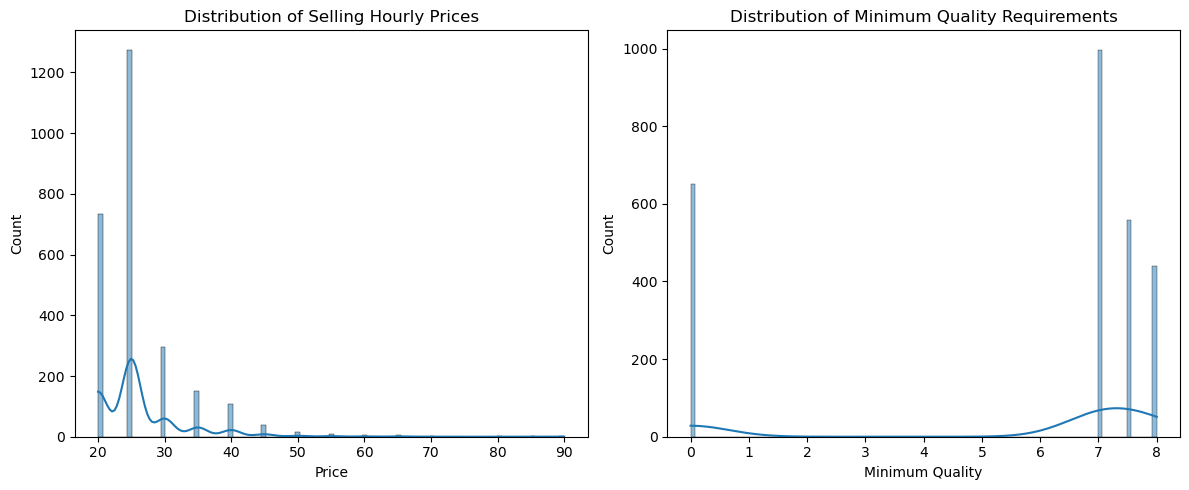

In [187]:
# Distribution - Selling prices & Minimum quality requirements
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(clients_df["SELLING_HOURLY_PRICE"], kde=True)
plt.title("Distribution of Selling Hourly Prices")
plt.xlabel("Price")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(clients_df["MIN_QUALITY"], kde=True)
plt.title("Distribution of Minimum Quality Requirements")
plt.xlabel("Minimum Quality")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

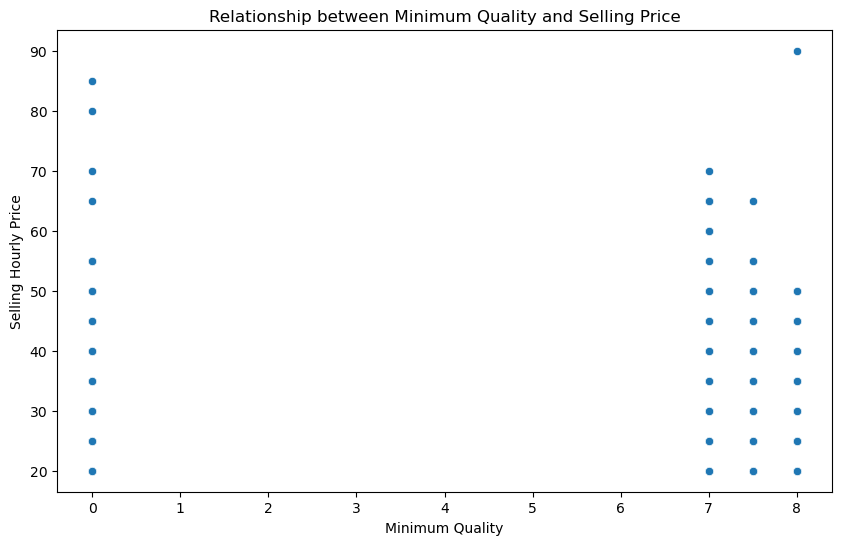

In [188]:
# Analyze relationship - Selling price & Minimum quality
plt.figure(figsize=(10, 6))
sns.scatterplot(x="MIN_QUALITY", y="SELLING_HOURLY_PRICE", data=clients_df)
plt.title("Relationship between Minimum Quality and Selling Price")
plt.xlabel("Minimum Quality")
plt.ylabel("Selling Hourly Price")
plt.show()

#### CSV Schedule

In [189]:
# Parse dates
if schedules_df["START"].dtype == "object":
    schedules_df["START"] = pd.to_datetime(schedules_df["START"], errors="coerce")
    schedules_df["END"] = pd.to_datetime(schedules_df["END"], errors="coerce")

/var/folders/mn/5b1ysnv91r7c936pgxljq3v80000gn/T/ipykernel_4480/3149020227.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  schedules_df["START"] = pd.to_datetime(schedules_df["START"], errors="coerce")
/var/folders/mn/5b1ysnv91r7c936pgxljq3v80000gn/T/ipykernel_4480/3149020227.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  schedules_df["END"] = pd.to_datetime(schedules_df["END"], errors="coerce")


In [190]:
print("Basic information:")
schedules_df.info()

Basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   NAME    983 non-null    object        
 1   START   983 non-null    datetime64[ns]
 2   END     983 non-null    datetime64[ns]
 3   MON     983 non-null    int64         
 4   TUES    983 non-null    int64         
 5   WED     983 non-null    int64         
 6   THURS   983 non-null    int64         
 7   FRI     983 non-null    int64         
 8   SAT     983 non-null    int64         
 9   SUN     983 non-null    int64         
dtypes: datetime64[ns](2), int64(7), object(1)
memory usage: 76.9+ KB


In [191]:
print("Statistical summary:")
display(schedules_df.describe().round(2))

Statistical summary:


,START,END,MON,TUES,WED,THURS,FRI,SAT,SUN
count,983,983,983.00,983.00,983.00,983.00,983.00,983.00,983.00
mean,2025-03-13 08:44:00.488301056,2025-03-13 18:13:14.710071296,0.74,0.73,0.73,0.73,0.74,0.42,0.43
min,2025-03-13 00:00:00,2025-03-13 00:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2025-03-13 08:00:00,2025-03-13 18:00:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2025-03-13 09:00:00,2025-03-13 19:00:00,1.00,1.00,1.00,1.00,1.00,0.00,0.00
75%,2025-03-13 10:00:00,2025-03-13 20:00:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
max,2025-03-13 23:00:00,2025-03-13 23:00:00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
std,NaN,NaN,0.44,0.44,0.44,0.44,0.44,0.49,0.49


In [192]:
print("CSV Schedules Data")
display(schedules_df.head())

CSV Schedules Data


,NAME,START,END,MON,TUES,WED,THURS,FRI,SAT,SUN
0,Abigail,2025-03-13 08:00:00,2025-03-13 18:00:00,1,1,1,1,1,0,0
1,Abelardo,2025-03-13 06:00:00,2025-03-13 16:00:00,1,1,1,1,1,1,1
2,Margarita,2025-03-13 08:00:00,2025-03-13 18:00:00,1,1,1,1,1,1,1
3,Davide,2025-03-13 09:00:00,2025-03-13 19:00:00,1,1,1,1,1,1,1
4,Paul,2025-03-13 07:00:00,2025-03-13 17:00:00,1,1,1,1,1,1,1


In [193]:
# TODO - Fix this error in preprocessing step

# Duration in hours for each row
schedules_df["HOURS"] = (schedules_df["END"] - schedules_df["START"]).dt.total_seconds() / 3600

# Group by NAME and sum the hours
total_hours_per_name = schedules_df.groupby("NAME")["HOURS"].sum().reset_index()


# Obtain ONLY
negative_hours = total_hours_per_name[total_hours_per_name["HOURS"] < 0]


print("Total Hours Per Name:")
display(total_hours_per_name)

if not negative_hours.empty:
    print("Names with Negative Hours (Incorrect Data):")
    display(negative_hours)
else:
    print("No negative hours detected")


Total Hours Per Name:


,NAME,HOURS
0,Aaron,10.0
1,Abdon,10.0
2,Abdon Isaias,10.0
3,Abdon Luis,10.0
4,Abel Irene,10.0
...,...,...
978,Zacarias Casio,10.0
979,Zacarias Marcelino,10.0
980,Zachary,10.0
981,Zlatan,10.0


Names with Negative Hours (Incorrect Data):


,NAME,HOURS
44,Alejandria,-14.0
71,Almudena Jorge,-14.0
85,Amelia,-14.0
145,Araceli Enrique,-14.0
151,Aresio Casimiro,-14.0
238,Carmen Maria,-14.0
247,Catherine,-14.0
341,Edgar,-14.0
365,Emanuel,-14.0
410,Federico Alipio,-14.0


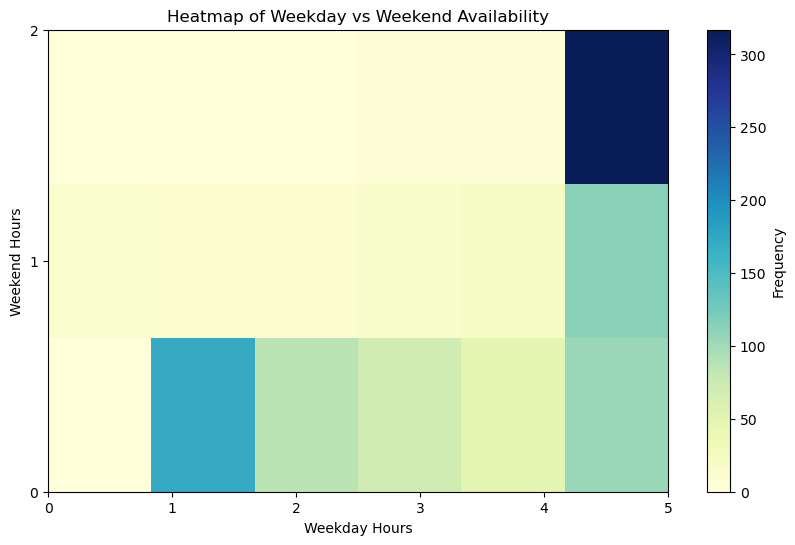

In [194]:
# TODO - Overworking hours...

# Calculate weekday and weekend hours directly
weekday_hours = schedules_df[["MON", "TUES", "WED", "THURS", "FRI"]].sum(axis=1)
weekend_hours = schedules_df[["SAT", "SUN"]].sum(axis=1)

# Create a heatmap of weekday vs weekend hours
heatmap_data, x_edges, y_edges = np.histogram2d(weekday_hours, weekend_hours, bins=(6, 3))

# Plot the heatmap
plt.figure(figsize=(10, 6))
plt.imshow(heatmap_data.T, origin="lower", cmap="YlGnBu", aspect="auto",
           extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar(label="Frequency")
plt.title("Heatmap of Weekday vs Weekend Availability")
plt.xlabel("Weekday Hours")
plt.ylabel("Weekend Hours")
plt.xticks(range(int(x_edges[0]), int(x_edges[-1]) + 1))
plt.yticks(range(int(y_edges[0]), int(y_edges[-1]) + 1))
plt.show()


#### CSV Translators Cost Pairs

In [195]:
print(f"Number of unique translators: {translators_df['TRANSLATOR'].nunique()}")
print(f"Number of source languages: {translators_df['SOURCE_LANG'].nunique()}")
print(f"Number of target languages: {translators_df['TARGET_LANG'].nunique()}")
print(f"Number of unique language pairs: {translators_df.groupby(['SOURCE_LANG', 'TARGET_LANG']).ngroups}")

Number of unique translators: 983
Number of source languages: 40
Number of target languages: 80
Number of unique language pairs: 300


#### CSV Sample

In [196]:
print("Basic information:")
sample_df.info()

Basic information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31017 entries, 0 to 31016
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   PROJECT_ID                   31017 non-null  object 
 1   PM                           31017 non-null  object 
 2   TASK_ID                      31017 non-null  int64  
 3   START                        31017 non-null  object 
 4   END                          31017 non-null  object 
 5   TASK_TYPE                    31017 non-null  object 
 6   SOURCE_LANG                  31017 non-null  object 
 7   TARGET_LANG                  31017 non-null  object 
 8   TRANSLATOR                   31017 non-null  object 
 9   ASSIGNED                     31017 non-null  object 
 10  READY                        31017 non-null  object 
 11  WORKING                      31017 non-null  object 
 12  DELIVERED                    31017 non-null  object 
 1

In [197]:
print("Missing values by column:")
print(sample_df.isnull().sum())

Missing values by column:
PROJECT_ID                     0
PM                             0
TASK_ID                        0
START                          0
END                            0
TASK_TYPE                      0
SOURCE_LANG                    0
TARGET_LANG                    0
TRANSLATOR                     0
ASSIGNED                       0
READY                          0
WORKING                        0
DELIVERED                      0
RECEIVED                       0
CLOSE                          0
FORECAST                       0
HOURLY_RATE                    0
COST                           0
QUALITY_EVALUATION             0
MANUFACTURER                   0
MANUFACTURER_SECTOR            0
MANUFACTURER_INDUSTRY_GROUP    0
MANUFACTURER_INDUSTRY          0
MANUFACTURER_SUBINDUSTRY       0
dtype: int64


In [198]:
# Count unique values for categorical columns
categorical_cols = ["PM", "TASK_TYPE", "SOURCE_LANG", "TARGET_LANG", 
                   "TRANSLATOR", "MANUFACTURER", "MANUFACTURER_SECTOR",
                   "MANUFACTURER_INDUSTRY_GROUP", "MANUFACTURER_INDUSTRY", 
                   "MANUFACTURER_SUBINDUSTRY"]

print("Unique values for Categorical columns:")
print()
for col in categorical_cols:
    print(f"{col}: {sample_df[col].nunique()} unique values")

Unique values for Categorical columns:

PM: 4 unique values
TASK_TYPE: 6 unique values
SOURCE_LANG: 11 unique values
TARGET_LANG: 18 unique values
TRANSLATOR: 228 unique values
MANUFACTURER: 250 unique values
MANUFACTURER_SECTOR: 14 unique values
MANUFACTURER_INDUSTRY_GROUP: 70 unique values
MANUFACTURER_INDUSTRY: 85 unique values
MANUFACTURER_SUBINDUSTRY: 92 unique values


In [199]:
# Columns with possible repetitive information
sample_df[["MANUFACTURER", "MANUFACTURER_SECTOR", "MANUFACTURER_INDUSTRY_GROUP", "MANUFACTURER_INDUSTRY", "MANUFACTURER_SUBINDUSTRY"]].head()

,MANUFACTURER,MANUFACTURER_SECTOR,MANUFACTURER_INDUSTRY_GROUP,MANUFACTURER_INDUSTRY,MANUFACTURER_SUBINDUSTRY
0,Coastal Cottage,Consumer Discretionary,Consumer Services,"Hotels, Restaurants & Leisure","Hotels, Resorts & Cruise Lines"
1,HealthyLife,Health Care,Health Care Providers,Health Care Facilities,Long-Term Care Facilities
2,AeroSysTech,Information Technology,Software & Services,Application Software,Systems Software
3,MetaPro,Industrials,Electrical Equipment,Electrical Components & Equipment,Electrical Components & Equipment
4,SunTech,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals"


In [200]:
print(f"Number of unique projects: {sample_df['PROJECT_ID'].nunique()}")
print(f"Number of unique tasks: {sample_df['TASK_ID'].nunique()}")
print(f"Number of unique translators: {sample_df['TRANSLATOR'].nunique()}")
print(f"Number of source languages: {sample_df['SOURCE_LANG'].nunique()}")
print(f"Number of target languages: {sample_df['TARGET_LANG'].nunique()}")
print(f"Number of unique task types: {sample_df['TASK_TYPE'].nunique()}")

Number of unique projects: 1720
Number of unique tasks: 31009
Number of unique translators: 228
Number of source languages: 11
Number of target languages: 18
Number of unique task types: 6


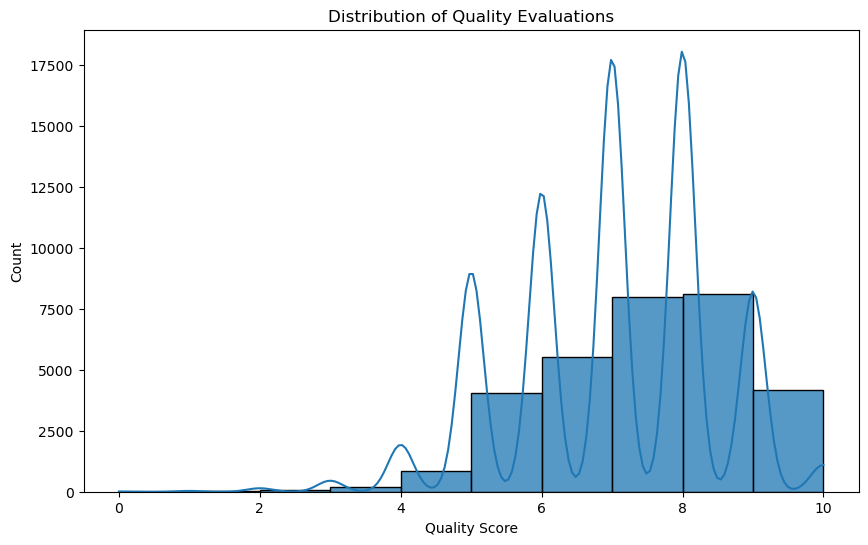

In [201]:
# Check distribution of quality evaluations (quality control scores)
plt.figure(figsize=(10, 6))
sns.histplot(sample_df["QUALITY_EVALUATION"].dropna(), bins=10, kde=True, alpha=0.75)
plt.title("Distribution of Quality Evaluations")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()


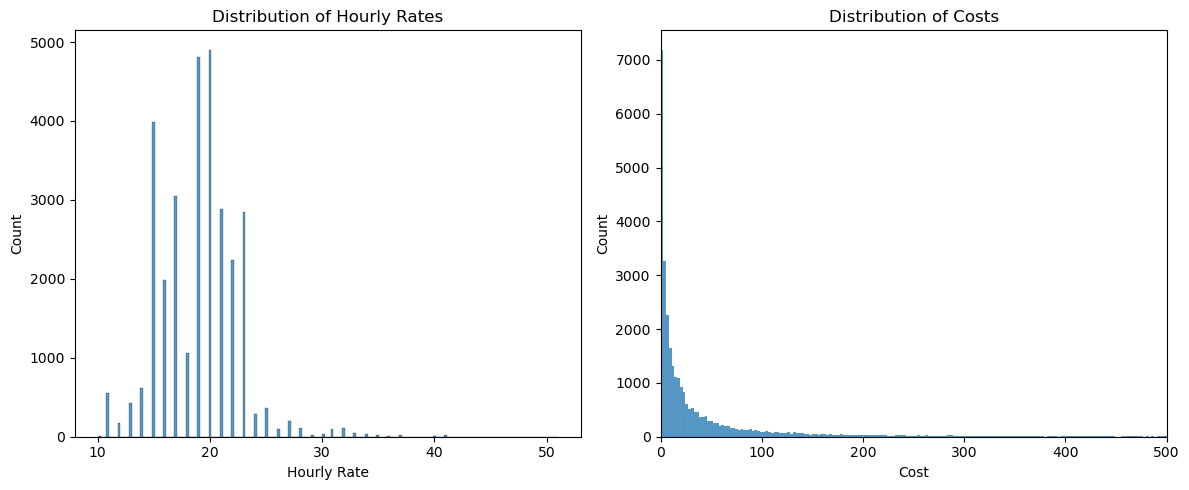

In [202]:
# Distribution of hourly rates and costs
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(sample_df["HOURLY_RATE"].dropna())
plt.title("Distribution of Hourly Rates")
plt.xlabel("Hourly Rate")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.histplot(sample_df["COST"].dropna())
plt.title("Distribution of Costs")
plt.xlim(0, 500)
plt.xlabel("Cost")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## Data Cleaning and Preprocessing

In [203]:
def standardize_language(lang, database):
    """
    Standardize a language name to match a reference list using Levenshtein distance

    Parameters:
    lang (str): Language to standardize
    database (list): List of reference language names

    Returns:
    str: Standardized language name
    """
    # Lowercase the language name
    reference_list = [x.lower() for x in database if isinstance(x, str)]
    
    # Levenshtein distance to get the closest match
    closest = difflib.get_close_matches(lang.lower(), reference_list, n=1, cutoff=0)[0]
    
    # Get the index of the closest match and return the original case from reference_list
    index = reference_list.index(closest)
    
    return database[index]

# Database
all_languages = np.sort(pd.concat([
    sample_df["SOURCE_LANG"],
    sample_df["TARGET_LANG"],
    translators_df["SOURCE_LANG"],
    translators_df["TARGET_LANG"]
]).dropna().unique())

In [204]:
all_languages

array(['Afrikaans', 'Arabic', 'Asturian', 'Aymara', 'Azeri', 'Bahasa',
       'Basque', 'Belorussian', 'Bulgarian', 'Catalan',
       'Chinese (Simplified)', 'Chinese(Traditional)', 'Chuj', 'Croat',
       'Czech', 'Danish', 'Dutch', 'English', 'English (UK)',
       'English (US)', 'Estonian', 'Finnish', 'Flemish', 'French',
       'French (Canadian)', 'French (Morocco)', 'French (Switzerland)',
       'Fulah', 'Galician', 'German', 'German (Switzerland)', 'Greek',
       'Guaraní', 'Hebrew', 'Hindi', 'Hungarian', 'Indonesian', 'Irish',
       'Italian', 'Japanese', 'Kaqchikel', 'Kazakh', 'Korean', 'Latvian',
       'Lithuanian', 'Majorcan', 'Maltese', 'Mam', 'Mixteco', 'Nahuatl',
       'Norwegian', 'Persian', 'Polish', 'Portuguese (Brazil)',
       'Portuguese (Iberian)', 'Portuguese (SOURCE)', 'Qeqchi', 'Quechua',
       'Quiche', 'Romanian', 'Russian', 'Scottish', 'Serbian', 'Slovak',
       'Slovenian', 'Spanish (Argentina)', 'Spanish (Chile)',
       'Spanish (Global)', 'Spanish

```python
# Example
new_input_lang = "Spanish (Iberiano)"

# Standardize the language
standardized_lang = standardize_language(new_input_lang, all_languages)
print(standardized_lang) 


# Example using Dataframe
new_record = pd.DataFrame([{
    "PROJECT_ID": 213495,
    "PM": "JSM",
    "TASK_ID": 10048286,
    "START": "2014-11-27 09:00:00",
    "END": "2014-11-27 13:00:00",
    "TASK_TYPE": "Translation",
    "SOURCE_LANG": "Spanishh (Iberian)",
    "TARGET_LANG": "Englisasdh",
    "TRANSLATOR": "Carlos",
    "ASSIGNED": "2014-11-27 08:30:00",
    "CLOSE": "2014-11-27 14:00:00",
    "FORECAST": 0.5,
    "HOURLY_RATE": 30,
    "COST": 15.0,
    "QUALITY_EVALUATION": 8,
    "MANUFACTURER": "Global Tech",
    "MANUFACTURER_SECTOR": "Technology",
    "MANUFACTURER_INDUSTRY_GROUP": "Software & Services",
    "MANUFACTURER_INDUSTRY": "IT Services",
    "MANUFACTURER_SUBINDUSTRY": "Data Processing & Outsourced Services"
}])

# Dataframe
new_record_df = new_record

# Display results
display(new_record_df)

new_record_df["SOURCE_LANG"] = new_record_df["SOURCE_LANG"].apply(standardize_language, database=all_languages)
new_record_df["TARGET_LANG"] = new_record_df["TARGET_LANG"].apply(standardize_language, database=all_languages)

display(new_record_df)


````